## Stock Price Prediction (SPY)

### Problem Statement

Our goal is to predict the daily adjusted closing prices of SPDR S&P 500 ETF Trust (SPY) using data from the previous 60 days.

### Methodology

We will use a particular kind of artificial recurrent neural network called Long Short Term Memory (LSTM) which is capable of learning long-term dependencies.They are networks with loops in them, allowing information information to flow from one step to the next. LSTM can store past information which is important and forget the information that is not improtant according to weights for forget gates. It is commonly used in text generation, handwriting recognition, music generation, language translation as well as weather or stock price forecast.

### Data

We will use five years of historical prices for SPY from 01/01/2015 to 12/31/2019, which can be easily downloaded from [Yahoo finance](https://finance.yahoo.com/quote/SPY/).  
(2020 data is excluded since pandemic related recession is not experienced frequently in history.)

In [2]:
# Import libraries

import math
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2024-12-15 18:26:18.761853: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 18:26:18.762594: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 18:26:18.765545: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 18:26:18.772787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734287178.784996   37941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734287178.78

In [3]:
# Read the stock data
file_path = 'sp500_stocks_final.csv'
spy_df = pd.read_csv(file_path)

### EDA

In [4]:
spy_df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,43.783867,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,43.509628,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,44.126682,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,44.158325,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,44.469463,70.501671,70.501671,69.648827,69.974915,4073337.0
...,...,...,...,...,...,...,...,...
1788643,2024-12-02,ZTS,176.809998,176.809998,176.910004,173.729996,175.779999,2391500.0
1788644,2024-12-03,ZTS,176.940002,176.940002,181.399994,176.559998,176.710007,2679000.0
1788645,2024-12-04,ZTS,175.320007,175.320007,178.500000,174.539993,174.600006,2687000.0
1788646,2024-12-05,ZTS,174.770004,174.770004,176.529999,173.720001,175.270004,2442000.0


In [5]:
# Number of rows and columns in the dataframe
spy_df.shape

(1788648, 8)

In [6]:
# Plot the closing price history of the stock
spy_df["Date"]=pd.to_datetime(spy_df["Date"])
spy_df= spy_df.groupby('Date').mean(numeric_only=True).reset_index()

spy_df.tail(236)


,Date,Adj Close,Close,High,Low,Open,Volume
3522,2024-01-02,188.150041,189.815724,191.928406,187.617103,189.586943,5.797049e+06
3523,2024-01-03,185.694069,187.338699,190.207413,186.085485,188.823455,5.655548e+06
3524,2024-01-04,185.447065,187.082640,189.303142,185.997228,187.209653,5.459105e+06
3525,2024-01-05,185.442961,187.077776,189.012585,185.585480,186.793383,5.337815e+06
3526,2024-01-08,187.791361,189.437952,189.921020,186.018603,187.215215,5.998887e+06
...,...,...,...,...,...,...,...
3753,2024-12-02,231.622193,231.649413,234.030774,229.489819,232.419002,5.506113e+06
3754,2024-12-03,231.323523,231.346312,233.470238,229.224110,231.734821,5.304658e+06
3755,2024-12-04,231.365696,231.382436,233.802925,228.775288,231.287983,5.406926e+06
3756,2024-12-05,229.912186,229.912186,233.117808,228.294930,231.117346,5.337675e+06


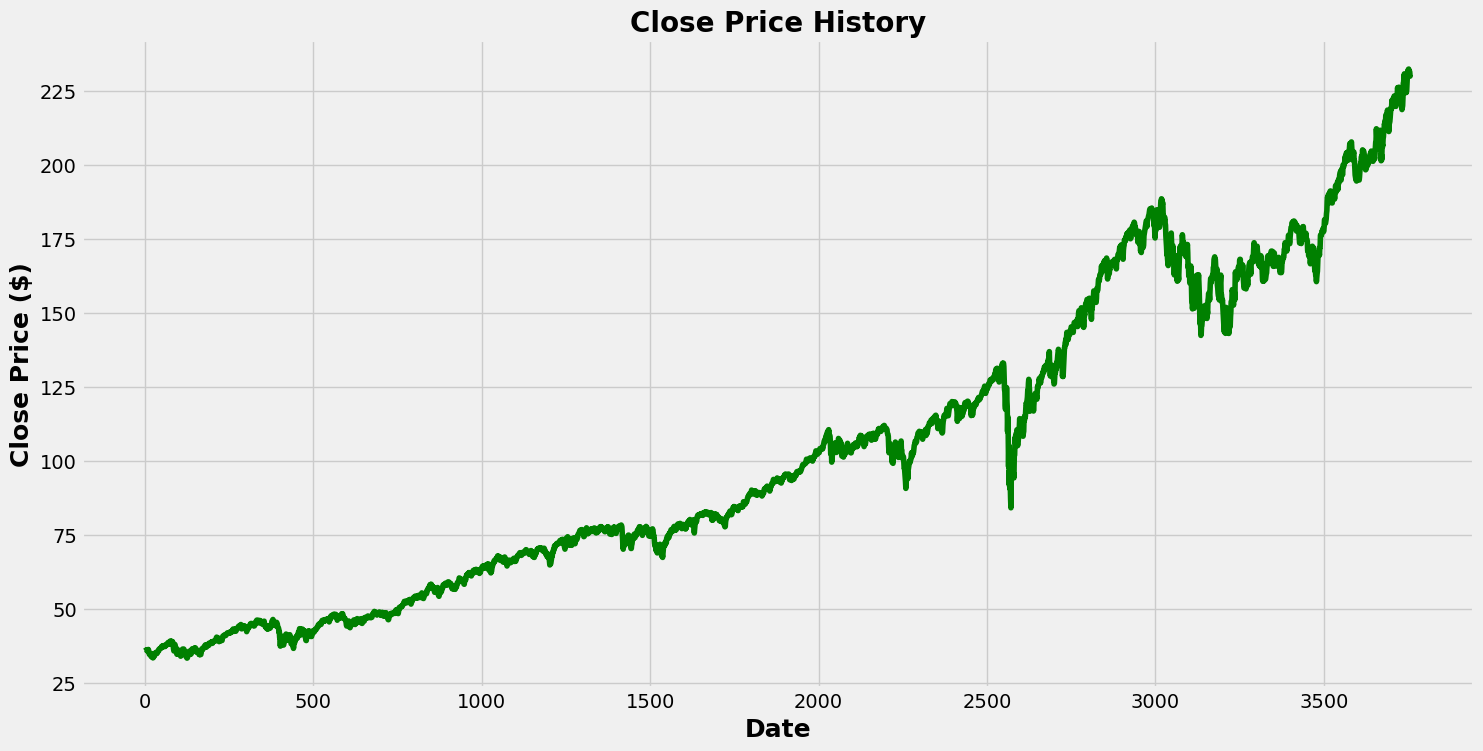

In [7]:
plt.figure(figsize=(16,8))
plt.title('Close Price History', fontweight='bold', fontsize=20)
plt.plot(spy_df['Close'], color='green')
plt.xlabel('Date', fontsize=18, fontweight='bold')
plt.ylabel('Close Price ($)', fontsize=18, fontweight='bold')
plt.show()

In [8]:
# Create a new dataframe with only Close column
close_spy_df = spy_df.filter(['Close'])

In [9]:
# Save the price values to a numpy array
close_spy_arr = close_spy_df.values

In [10]:
# Get the length of training data
train_size = int(np.round(len(close_spy_arr)))-236

In [11]:
train_size

3522

### Data Preprocessing

We will use MinMaxScaler estimator to transform the prices such that they are in the given range on the training set (between zero and one inclusive).

In [12]:
sc = MinMaxScaler(feature_range=(-1,1))
close_spy_arr_scaled = sc.fit_transform(close_spy_arr[:train_size])
close_spy_arr_scaled

array([[-0.96965913],
       [-0.96856431],
       [-0.96822686],
       ...,
       [ 0.99924822],
       [ 1.        ],
       [ 0.99539094]])

In [13]:
# Create the scaled train data set
train_scaled = close_spy_arr_scaled[0:train_size, :]

In [14]:
train_scaled

array([[-0.96965913],
       [-0.96856431],
       [-0.96822686],
       ...,
       [ 0.99924822],
       [ 1.        ],
       [ 0.99539094]])

In [15]:
# Create x_train_scaled y_train_scaled data sets

x_train_scaled = [] # empty list
y_train_scaled = [] # empty list

for i in range(60, len(train_scaled)):
    x_train_scaled.append(train_scaled[i-60:i, 0]) # previous 60 days of values
    y_train_scaled.append(train_scaled[i, 0]) # target value    

In [16]:
# Print first values from both x_train_scaled and y_train_scaled
# First 60 days values (feature) & 61th day value (target)
x_train_scaled[0], y_train_scaled[0]

(array([-0.96965913, -0.96856431, -0.96822686, -0.96590838, -0.96509327,
        -0.96406647, -0.96868636, -0.96459064, -0.9644181 , -0.96898426,
        -0.96291138, -0.9673555 , -0.97473652, -0.98366589, -0.98208337,
        -0.98395323, -0.98292419, -0.98853465, -0.99239821, -0.98610156,
        -0.98054291, -0.98334331, -0.99670721, -0.99609942, -0.9989116 ,
        -0.99376591, -0.99486261, -0.99107495, -0.99065088, -0.98254931,
        -0.98021306, -0.97737115, -0.97576372, -0.97610957, -0.98117819,
        -0.97763735, -0.97810556, -0.97708158, -0.97157454, -0.96937826,
        -0.96952115, -0.96853258, -0.96115998, -0.96048544, -0.96023928,
        -0.95831378, -0.95708057, -0.95704943, -0.95761593, -0.95307704,
        -0.94925212, -0.94952215, -0.95245023, -0.94912323, -0.9464187 ,
        -0.94966676, -0.95072837, -0.95075862, -0.94778855, -0.94731142]),
 np.float64(-0.9501375730391131))

In [17]:
# Convert x_train_scaled and y_train_scaled lists to numpy arrays
x_train_scaled,y_train_scaled = np.array(x_train_scaled),np.array(y_train_scaled)

In [18]:
# Reshape the train data as 3-dimensional array
x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], x_train_scaled.shape[1], 1))

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_best_lstm(input_dim, hidden_dim=30, output_dim=1, dropout_rate=0.3, num_layers=2):
    """
    Create the best LSTM model for regression.
    
    Parameters:
        input_dim (int): Number of input features.
        hidden_dim (int): Number of units in each LSTM layer.
        output_dim (int): Number of outputs (default is 1 for regression).
        dropout_rate (float): Dropout rate for regularization.
        num_layers (int): Number of stacked LSTM layers.
    
    Returns:
        model (tf.keras.Model): Compiled LSTM model.
    """
    model = Sequential()
    tf.keras.backend.clear_session()
    # First LSTM layer with return_sequences=True for stacking
    model.add(LSTM(hidden_dim, return_sequences=(num_layers > 1), input_shape=(None, input_dim)))
    model.add(Dropout(dropout_rate))
    
    # Additional LSTM layers (if any)
    for _ in range(num_layers - 1):
        model.add(LSTM(hidden_dim, return_sequences=(_ < num_layers - 2)))
        model.add(Dropout(dropout_rate))
    
    # Dense output layer
    model.add(Dense(output_dim))
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']  # Mean Absolute Error for interpretability
    )
    
    return model

# Example: Create the model
input_dim = 1  # Number of features
hidden_dim = 64  # Larger hidden size for better learning
output_dim = 1  # Predicting one value (e.g., next day's closing price)
num_layers = 3  # Stacked LSTM layers for deeper learning
dropout_rate = 0

model = create_best_lstm(input_dim, hidden_dim, output_dim, dropout_rate=dropout_rate, num_layers=num_layers)

2024-12-15 18:26:22.573350: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/pedro/Documents/UNI/_3_ano/LAB_IACD/project_2/S-P_500_Stock_Prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history_obj=model.fit(x_train_scaled, y_train_scaled, epochs=50,   
          batch_size=64, verbose=1, validation_split=0.2,
          callbacks=[ EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-6)])

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0706 - mae: 0.1824 - val_loss: 0.0073 - val_mae: 0.0725 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0016 - mae: 0.0264 - val_loss: 0.0152 - val_mae: 0.1095 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0014 - mae: 0.0213 - val_loss: 0.0109 - val_mae: 0.0911 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0012 - mae: 0.0200 - val_loss: 0.0091 - val_mae: 0.0828 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0012 - mae: 0.0195 - val_loss: 0.0073 - val_mae: 0.0735 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0012 - mae: 0.0195 - val_loss: 0.0068 - val_mae: 0.0707 - learning_rate: 0.0010
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0011 - mae: 0.0185 - val_loss: 0.0038 - val_mae: 0.0511 - learning_rate: 0.0010
Epoch 8/50
44

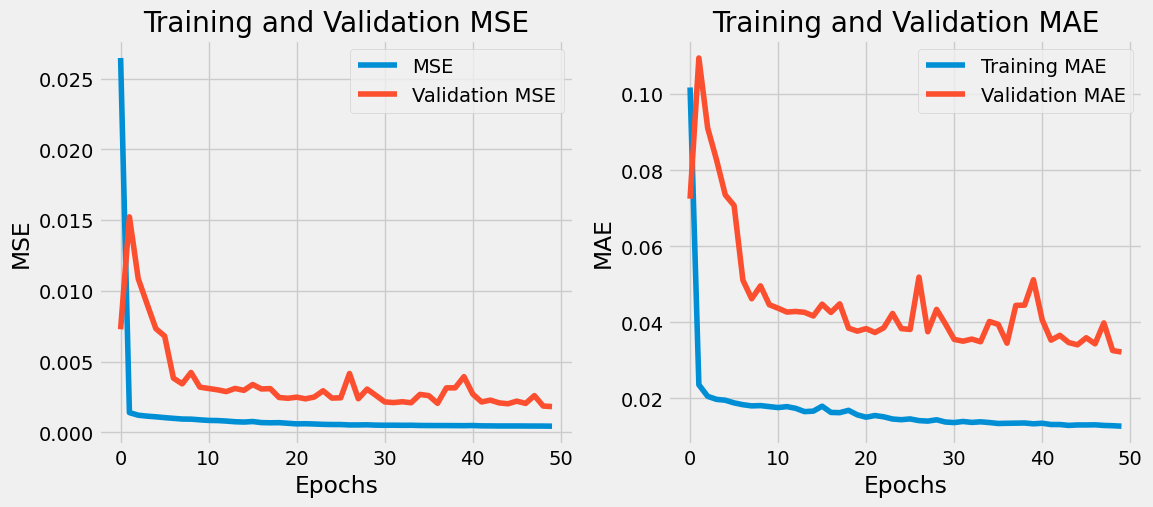

In [21]:
plt.figure(figsize=(12, 5))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history_obj.history['loss'], label='MSE')
plt.plot(history_obj.history['val_loss'], label='Validation MSE')
plt.title("Training and Validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_obj.history['mae'], label='Training MAE')
plt.plot(history_obj.history['val_mae'], label='Validation MAE')
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [59]:
def recursive_predict(model, initial_data, days_to_predict):
    """
    Perform recursive multi-step prediction using the model.
    
    Parameters:
        model: Trained RNN model.
        initial_data (numpy.ndarray): Last 60 days of real data (shape: (60, num_features)).
        days_to_predict (int): Number of days to predict (e.g., 31 for January).
    
    Returns:
        numpy.ndarray: Predicted values for the specified number of days.
    """
    predictions = []
    current_data = initial_data.copy()  # Start with the last 60 days of real data
    
    for _ in range(days_to_predict):
        # Reshape current data to match model input (1 sample, 60 timesteps, num_features)
        input_data = current_data[-60:].reshape(1, 60, 1)
        # Predict the next day's value
        next_prediction = model.predict(input_data).flatten()[0]
        predictions.append(next_prediction)
        
        # Update current data with the new prediction
        # Here, we assume the prediction is for a single feature (e.g., Adj Close)
        next_row = np.append(current_data[-1, 1:], next_prediction)  # Shift features forward
        current_data = np.vstack([current_data, next_row])
    
    return np.array(predictions)

In [60]:
days_to_predict = 21  # Predict the whole month of January
initial_data = close_spy_arr_scaled[train_size-60:train_size , :]  # Replace with the last 60 days before January 2024
predictions = recursive_predict(model, initial_data, days_to_predict)
predictions=predictions.reshape(-1,1)
predictions=sc.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/tmp/ipykernel_37941/894524175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


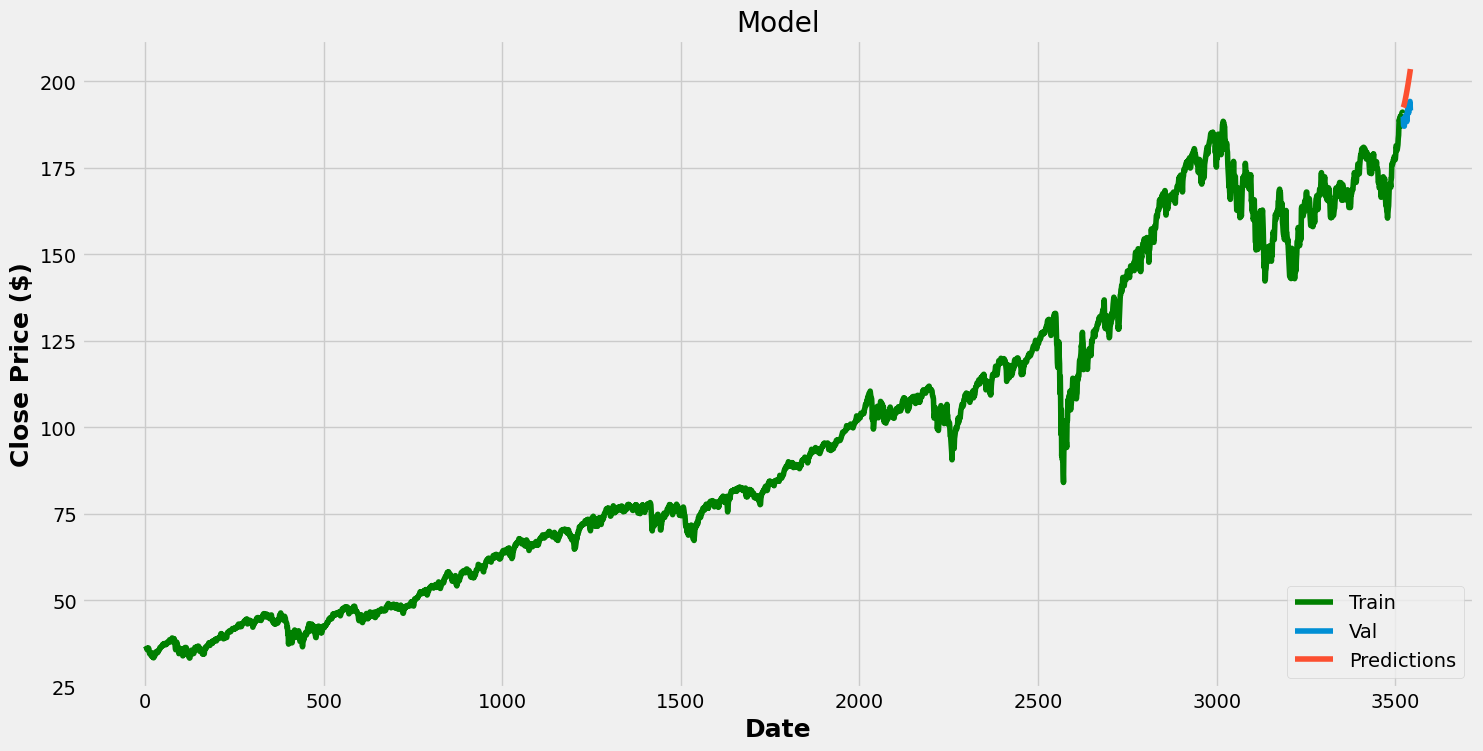

In [61]:
# Plot the actual values vs predictions
train = close_spy_df[:train_size]
valid = close_spy_df[train_size:train_size+21]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18, fontweight='bold')
plt.ylabel('Close Price ($)', fontsize=18, fontweight='bold')
plt.plot(train['Close'], color='green')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [25]:
# Display actual prices vs predictions
valid

,Close,Predictions
3522,189.815724,192.496384
3523,187.338699,192.761856
3524,187.082640,193.095016
3525,187.077776,193.493164
3526,189.437952,193.942154
3527,188.847246,194.427094
3528,189.883870,194.936798
3529,190.162788,195.464386
3530,190.155537,196.006409
3531,189.565531,196.561737


It looks like the model is pretty decent predicting stock market prices based on past 60 days values.

Question: Can we rely on a robust LSTM network when making investment decisions?

Now we want to predict the prices for the stocks of each comapny in January 2024

To do so we need to have the last 60 days of 2023 for each comapny

In [26]:
df=pd.read_csv('sp500_stocks_final.csv')
df = df[df['Date'] < '2024-01-01']
df.head()
df.sort_values(by=['Symbol','Date'])

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
33068,2010-01-04,A,20.053026,22.389128,22.625179,22.267525,22.453505,3815561.0
33069,2010-01-05,A,19.835196,22.145924,22.331903,22.002861,22.324751,4186031.0
33070,2010-01-06,A,19.764729,22.067240,22.174536,22.002861,22.067240,3243779.0
33071,2010-01-07,A,19.739098,22.038628,22.045780,21.816881,22.017166,3095172.0
33072,2010-01-08,A,19.732685,22.031473,22.067240,21.745352,21.917025,3733918.0
...,...,...,...,...,...,...,...,...
1788407,2023-12-22,ZTS,193.067825,194.979996,195.910004,192.740005,195.320007,1548400.0
1788408,2023-12-26,ZTS,193.582733,195.500000,196.339996,194.089996,194.880005,814600.0
1788409,2023-12-27,ZTS,194.968979,196.899994,197.009995,194.740005,195.410004,766400.0
1788410,2023-12-28,ZTS,195.226456,197.160004,198.600006,196.529999,197.619995,880100.0


In [27]:
df_group=df.groupby('Symbol')
last_60_days = df_group[['Symbol', 'Close']].tail(60)
print(last_60_days)

        Symbol       Close
3462       MMM   73.436455
3463       MMM   73.913040
3464       MMM   74.456520
3465       MMM   75.785950
3466       MMM   75.576920
...        ...         ...
1788407    ZTS  194.979996
1788408    ZTS  195.500000
1788409    ZTS  196.899994
1788410    ZTS  197.160004
1788411    ZTS  197.369995

[29940 rows x 2 columns]


In [79]:
company_names=last_60_days['Symbol'].unique()
data=[]

for name in company_names:
    company_data = last_60_days[last_60_days['Symbol'] == name]


    input_data = company_data[['Close']].values  
    input_data = input_data.reshape(60, 1)  
    
    predictions = recursive_predict(model, input_data, days_to_predict)
    predictions=predictions.reshape(-1,1)
    predictions=sc.inverse_transform(predictions)

    predictions_dict={'Company':name}
    for i in range(1, days_to_predict+1):
        predictions_dict[f'Day {i}']= predictions[i-1][0]
    
    data.append(predictions_dict)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [84]:
df_predictions = pd.DataFrame(data)
print(df_predictions.shape)
df_predictions.head(5)


(499, 22)


,Company,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,...,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21
0,MMM,339.632721,342.300812,346.714722,352.185150,357.896179,363.327209,368.188599,372.347748,375.764160,...,381.690033,382.376343,382.521271,382.192657,381.451416,380.371002,379.025269,377.484833,375.810303,374.052063
1,AOS,348.383484,350.490295,354.056335,358.610321,363.429932,368.057007,372.186462,375.695862,378.542145,...,383.170593,383.565063,383.479980,382.970581,382.093811,380.916473,379.497528,377.902283,376.186340,374.396973
2,ABT,326.209686,329.808838,335.591003,342.519775,349.608398,356.253906,362.174042,367.270782,371.528229,...,379.468323,380.631348,381.154663,381.114716,380.594055,379.679565,378.456879,377.006042,375.396576,373.684845
3,ABBV,319.900970,323.913727,330.294006,337.868958,345.586090,352.800629,359.194153,364.671021,369.261810,...,378.247284,379.738495,380.550171,380.753357,380.430969,379.672577,378.568726,377.204346,375.653503,373.977509
4,ACN,314.229919,318.461853,325.476257,333.703400,342.011719,349.715210,356.488251,362.242340,367.015747,...,376.293304,377.951202,378.994019,379.465240,379.414612,378.911011,378.033386,376.861145,375.464935,373.905396


In [85]:
df_predictions.to_csv('predictions_each_company.csv')